In [1]:
# Importing numpy and all functions in implementations.py
import numpy as np
from implementations import *
import helpers as h
import matplotlib.pyplot as plt

In [2]:

def loadData(dataPath):
    ''' Loads data and returns it as masked numpy array. A masked array contains information about which values are invalid, ensuring methods like .mean() ignores the masked values
    Args:
        dataPath: The file path of the data
    Returns:
        data: (N,d) masked numpy array, where N is the number of samples, and d is the dimension of the x values, or 1 if the data in question are the labels
        header: (d,) array with the column names
    '''
    data = np.genfromtxt(dataPath, delimiter=',', skip_header=1, dtype=float, usemask=True) # Loading the data as a masked array (with usemask=True), skipping the header, and specifying that the values are floats
    header = np.genfromtxt(dataPath, delimiter=',', dtype=str, max_rows=1) # Loading the first row of the csv file, i.e. the header
    return data , header

# Loading the data and printing the shapes
y, yHeader = loadData('./Data/y_train.csv')
x, xHeader = loadData('./Data/x_train.csv')
print(f'y: {y.shape}, x: {x.shape}')

y: (328135, 2), x: (328135, 322)


In [3]:
print(np.sum(y,axis=0)/len(y))

[164067.0 -0.8233958584119341]


In [4]:
# Counting the number of valid values for each feature, and calculating the percentage of valid entries
validFeatureVals = x.count(axis=0)
validFeatureValsPercent = validFeatureVals/x.shape[0]

# Finding the indices of all the features with number of features above and below a threeshold
threeshold = 0.7
featureIndicesAboveThreeshold = np.argwhere(validFeatureValsPercent > threeshold).flatten() # Finding the indiced i where there are more than threeshold percent
featureIndicesBelowThreeshold = np.argwhere(validFeatureValsPercent < threeshold).flatten() # valid values, and flattening the array from (i,1) to (i,)
print(f'For a threeshold of {threeshold}, there are {len(featureIndicesAboveThreeshold)} valid features, and {len(featureIndicesBelowThreeshold)} invalid features')

For a threeshold of 0.7, there are 145 valid features, and 177 invalid features


In [5]:
# Removing the features that appears less than {threeshold} of the time
xFeaturesRemoved = x[:,featureIndicesAboveThreeshold]
xHeaderFeaturesRemoved = xHeader[featureIndicesAboveThreeshold]
print(xFeaturesRemoved.shape)

(328135, 145)


In [6]:
# Counting the number of valid values for each remaining sample
validSampleVals = xFeaturesRemoved.count(axis=1)
validSampleValsPercent = validSampleVals/xFeaturesRemoved.shape[1]

acceptableMissingValues = 5
sampleIndicesAboveThreeshold = np.argwhere(validSampleVals >= xFeaturesRemoved.shape[1]-acceptableMissingValues).flatten()
print(f'There are {len(sampleIndicesAboveThreeshold)} samples with at most {acceptableMissingValues} missing values, for a threeshold of {threeshold} for considering a feature valid')


There are 289870 samples with at most 5 missing values, for a threeshold of 0.7 for considering a feature valid


In [7]:
# Removing samples with more than {acceptableMissingValues} missing values
xFeaturesAndSamplesRemoved = xFeaturesRemoved[sampleIndicesAboveThreeshold]
ySamplesRemoved = y[sampleIndicesAboveThreeshold]
print(xFeaturesAndSamplesRemoved.shape)

(289870, 145)


In [8]:
print(f'The number of invalid entries remaing in the dataset is {xFeaturesAndSamplesRemoved.size - xFeaturesAndSamplesRemoved.count()}\nThat is {(xFeaturesAndSamplesRemoved.size - xFeaturesAndSamplesRemoved.count())/xFeaturesAndSamplesRemoved.size} parts of the whole dataset')

The number of invalid entries remaing in the dataset is 272938
That is 0.006493707643021902 parts of the whole dataset


In [9]:
xNormalize = (xFeaturesAndSamplesRemoved - np.mean(xFeaturesAndSamplesRemoved,axis=0)) / np.var(xFeaturesAndSamplesRemoved, axis=0)
xClean = np.ma.filled(xFeaturesAndSamplesRemoved,fill_value=0)
tx = np.c_[np.ones(xClean.shape[0]),xClean]

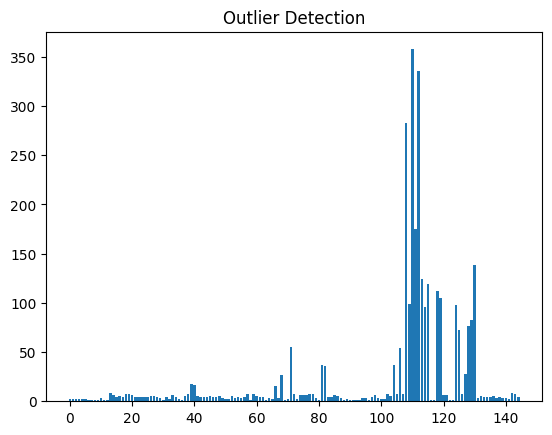

The indices of the samples with an outlier exceeding 30 times the average is: [ 10721    176    176      3      3 124409  19050  57839 193584  19532
  82465    140   2495 171281 124409   9095  16118      3  15285     59]


In [10]:
outlierArray = np.max(np.abs(xClean),axis=0)/np.mean(np.abs(xClean),axis=0)
outlierMultiple = 30
outlierSamples = np.argmax(xClean,axis=0)[np.where(outlierArray > outlierMultiple)]

# Bar chart of the largest element of each feature divided by the average element of the feature
'''TODO This should probably be done before the normalization - so that the outliers do not influence the mean and variance
I guess we should allow for max values no more than 10-50 times bigger than the average, so TODO these needs to be removed, 
either by removing the sample, or by replacing the outlier value by the mean. I think it is probably best to just remove the sample
We can probably do better than this, as now the code just checks the largest value for each feature, while we would want to TODO take into account 
the possibility of having multiple outliers for each feature'''
plt.bar(np.arange(0,xClean.shape[1]),outlierArray)
plt.title('Outlier Detection')
plt.show()
print(f'The indices of the samples with an outlier exceeding {outlierMultiple} times the average is: {outlierSamples}')

In [11]:
initial_w = np.ones(tx.shape[1],dtype=np.double)
w_sgd_m, loss_sgd_m, = mean_squared_error_sgd(ySamplesRemoved[:,1],tx,initial_w,10**4,2e-18,batch_size=16)
print(compute_loss(ySamplesRemoved[:,1],tx,initial_w),loss_sgd_m)

/Users/johannes/Documents/Uni/Semester7/MachineLearning/CS433_Project_1/ml-project-1-andermaxjohannes/implementations.py:55: RuntimeWarning: overflow encountered in matmul
  return - tx.T @ (y-tx @ w) / len(y)


1.6297739024223482e+19 --


/Users/johannes/Documents/Uni/Semester7/MachineLearning/CS433_Project_1/ml-project-1-andermaxjohannes/implementations.py:21: RuntimeWarning: overflow encountered in matmul
  return e.T @ e / len(e)


In [12]:
w_logistic = logistic_regression(ySamplesRemoved[:,1],tx,initial_w,10**3,1e-19)

/Users/johannes/Documents/Uni/Semester7/MachineLearning/CS433_Project_1/ml-project-1-andermaxjohannes/implementations.py:241: RuntimeWarning: divide by zero encountered in log
  return - np.sum( y * np.log(logistic(tx @ w)) + (1-y)* np.log(1-logistic(tx @ w)) ) / y.shape[0]


In [14]:
prediction = np.sign(tx @ w_logistic)
errors = np.sum(np.abs(prediction - ySamplesRemoved[:,1]))/2
predPos = np.sum(np.abs(prediction[np.where(prediction > 0)]))
print(f'''Number of Errors: {errors}
Predicted positive cases: {predPos}
Number of samples: {len(ySamplesRemoved)}
Number of actually positive cases: {np.sum(ySamplesRemoved[np.where(ySamplesRemoved[:,1] > 0 ),1])}''')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.